In [1]:
import theseus as th
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.autograd.set_detect_anomaly(True)
from tqdm import tqdm
from typing import List

# Defining NN model

In [2]:
# simple MLP model for initial tests
# in our initial 1-D test the input and output of the model will be 1 dimentional
class SimpleNN(nn.Module):
    def __init__(self, in_size, out_size, hid_size=30, use_offset=False):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_size, hid_size, bias=False),
            nn.ReLU(),
            nn.Linear(hid_size, hid_size, bias=False),
            nn.ReLU(),
            nn.Linear(hid_size, out_size, bias=False),
        )

    def forward(self, state_):
        return self.fc(state_)

# Generating data
Generating 1d data - random acceleration along 1 axis. No rotation or motion along other axes

In [3]:
def generate_data(B = 1, N = 10):
    return torch.randn((B,N))

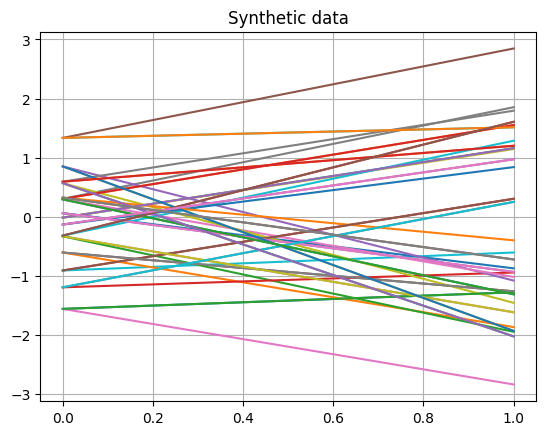

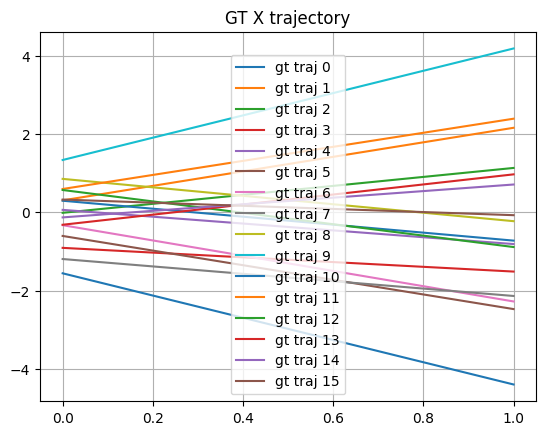

In [4]:
B = 16 # number of trajectories in batch
N = 2 # number of trajectory points

# window = 5

# generating random acceleration
input_acc = generate_data(B,N)
for i in range(B):
    plt.plot(input_acc[i,:], label=f'noiseless acc {i}')

# velocity dt = 1 sec
gt_vel = torch.cumsum(input_acc, dim=-1)

for i in range(B):
    plt.plot(gt_vel[i],label=f'gt velocity {i}')

# trjectory dt = 1sec
gt_traj = torch.cumsum(gt_vel, dim=-1)


# additive noise
# input_acc = input_acc + 2*torch.randn((B,N))

# multiplicative noise
# input_acc = input_acc*2*torch.randn((B,N))

for i in range(B):
    plt.plot(input_acc[i], label=f'acc + noise {i}')
plt.title("Synthetic data")
# plt.legend()
plt.grid()

plt.figure()
for i in range(B):
    plt.plot(gt_traj[i], label=f'gt traj {i}')
plt.title('GT X trajectory')
plt.legend()
plt.grid()

# Setting Theseus optimization variables, cost functions and layer

In [5]:
# 1d task - only moving along X axis w/o any rotation
model = SimpleNN(1, 1, hid_size=30)
model.train()
model

SimpleNN(
  (fc): Sequential(
    (0): Linear(in_features=1, out_features=30, bias=False)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=30, bias=False)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=1, bias=False)
  )
)

Now we set all optimization variables, gt and cost functions in theseus

In [6]:
# optimization variables for inner loop
poses : List[th.SE2] = []

# number of poses is the same as the number of nodes in trajectory
for i in range(N):
    poses.append(th.SE2(torch.zeros(B,3),name=f"pose_{i}"))

Defining cost functions

In [7]:
cost_functions = []

# adding cost factors for odometry
for i in range(N-1):
    # odometry measurmenets will depend on NN output
    pred_acc = model(input_acc[:,i].view(B,-1))  #<====== here we attach computational graph of NN to all the odometry factors via predicting acceleration
    meas_tensor = th.SE2(F.pad(pred_acc**2/2 + pred_acc, pad=(0,2)), name=f"predicted_odometry_{i}")

    # meas_tensor = th.SE2(torch.tensor([gt_traj[i+1] - gt_traj[i], 0, 0]).reshape(1,-1))
    cost_between = th.ScaleCostWeight(1.0, name=f"scale_between_{i}")
    cost_functions.append(
                th.Between(poses[i], poses[i+1], meas_tensor,
                        cost_between,
                        name=f"between_{i}"))
    
# adding cost fuctors for absolute position
for i in range(N):
    gt_pose_tensor = th.SE2(F.pad(gt_traj[:,i].view(B,-1), pad=(0,2)), name=f"gt_pose_{i}")
    scale_gps = th.ScaleCostWeight(1.0, name=f"scale_gps_{i}")
    cost_functions.append(th.Difference(poses[i], gt_pose_tensor, scale_gps, name=f"gps_{i}"))


Adding all the cost functions to the objective of inner-loop

In [8]:
objective = th.Objective()
for cost in cost_functions:
    objective.add(cost)

Checking what aux and optim variable the objective has:

In [9]:
print("+"*40)
print(f"AUX variables: {len(objective.aux_vars)}")
print("+"*40)
for c in objective.aux_vars:
    print(c)
print("+"*40)

print(f"Optimization variables: {len(objective.optim_vars)}")
print("+"*40)
for c in objective.optim_vars:
    print(c)
print("+"*40)


++++++++++++++++++++++++++++++++++++++++
AUX variables: 6
++++++++++++++++++++++++++++++++++++++++
predicted_odometry_0
Variable__9
gt_pose_0
Variable__13
gt_pose_1
Variable__17
++++++++++++++++++++++++++++++++++++++++
Optimization variables: 2
++++++++++++++++++++++++++++++++++++++++
pose_0
pose_1
++++++++++++++++++++++++++++++++++++++++


Defining optimizer for inner loop and theseus layer 

In [10]:
optimizer = th.GaussNewton(
        objective,
        th.CholeskyDenseSolver,
        max_iterations=3,
        step_size=0.1,
    )

state_estimator = th.TheseusLayer(optimizer)

Defining helper function to update theseus inputs for every training epoch

In [11]:
def run_model(nn_model, current_inputs_):

    # getting predicted accelerations here
    predicted_acc = nn_model(current_inputs_.view(-1,1)).view(B,-1)
    
    # doing manual double integration here
    theseus_inputs_ = {}
    for i in range(N-1):
        theseus_inputs_[f"predicted_odometry_{i}"] = F.pad(F.pad(F.pad((predicted_acc[:,i]**2/2 + predicted_acc[:,i]).view(B,-1),pad=(0,1)), pad=(0,1),value=1.0),pad=(0,1))

    return theseus_inputs_

In [12]:
# this plotting function will update some existing figure
plt.ion()

def plot_path(optimizer_path, groundtruth_path):
    plt.cla()
    # plt.gca().axis("equal")

    # plt.xlim(-25, 25)
    # plt.ylim(-10, 40)

    batch_idx = 0
    for i in range(B):
        plt.plot(
            optimizer_path[i],
            linewidth=2,
            linestyle="-",
            color="tab:orange",
            label="optimizer",
        )
        plt.plot(
            groundtruth_path[i],
            linewidth=2,
            linestyle="-",
            color="tab:green",
            label="groundtruth",
        )
    plt.title(f"mean squared error {F.mse_loss(torch.tensor(optimizer_path),groundtruth_path)}")
    plt.legend()
    plt.grid()
    plt.show()
    plt.pause(1e-12)

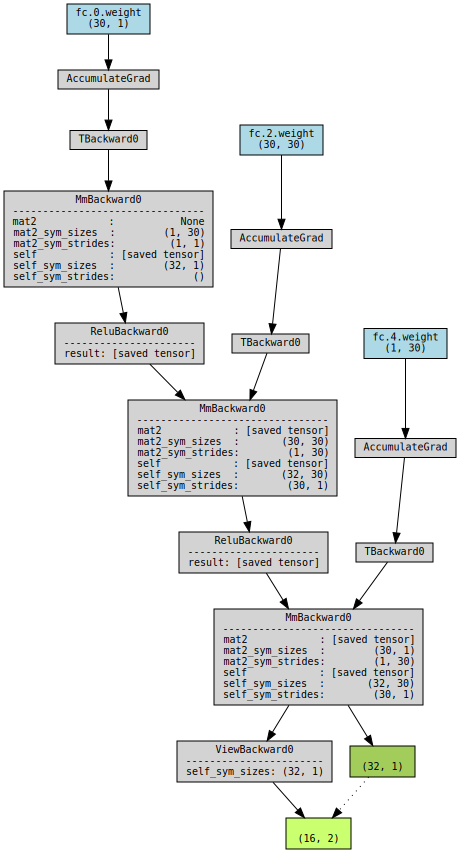

In [13]:
import torchviz

predicted_acc = model(input_acc.view(-1,1)).view(B,-1)

torchviz.make_dot(predicted_acc, params=dict(list(model.named_parameters())), show_attrs=True, show_saved=not True)

In [14]:
# theseus_inputs = {}
# predicted_odometry = run_model(model, input_acc)
# theseus_inputs.update(predicted_odometry)
# result = state_estimator.forward(theseus_inputs)

In [15]:
# torchviz.make_dot(state_estimator.forward(theseus_inputs)[0]['pose_0'], 
#                   params=dict(state_estimator.named_parameters()))

In [16]:
n_epoch = 20

model_optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)

losses = []

with torch.autograd.detect_anomaly():
    for epoch in tqdm(range(n_epoch)):
        model_optimizer.zero_grad()

        # preparing theseus inputs
        # we ran input acc signals through the NN and get some output acc values (NN model is our observation function)
        # after model inference we do manual integration of model output - tensor graph should preserved
        theseus_inputs = {}
        predicted_odometry = run_model(model, input_acc)
        theseus_inputs.update(predicted_odometry)
        
        # predicted_acc = model(input_acc.view(-1,1)).view(B,-1)

        # torchviz.make_dot(predicted_acc.mean(), params=dict(model.named_parameters()), show_attrs=not True, show_saved=not True)

        # here we update AUX variables (predicted incremental poses updated here)
        objective.update(theseus_inputs)
        print(f"Objective error = {objective.error_metric().mean().item()}")

        # checking that the number of variables not gowing
        print("+"*40)
        print(f"AUX variables: {len(objective.aux_vars)}")
        print("+"*40)
        for c in objective.aux_vars:
            print(c)
        print("+"*40)

        print(f"Optimization variables: {len(objective.optim_vars)}")
        print("+"*40)
        for c in objective.optim_vars:
            print(c)
        print("+"*40)

        # inner loop optimization is here
        # inner loop optimization result will be store into the theseus_inputs dictionary (pose_i - objects - optimization variables)
        theseus_output, _ = state_estimator.forward(
                theseus_inputs,
                optimizer_kwargs={
                    "track_best_solution": True,
                    "verbose": epoch % 2 == 0,
                },
            )

        # here we transform trajectory from optimizator
        optimized_path = torch.empty(B,N,1)
        for i in range(N):
            optimized_path[:, i] = theseus_output[f"pose_{i}"][0,0]

        gt_path = torch.empty((B,N,1))
        for i in range(N):
            gt_path[:, i, 0] = gt_traj[:,i]

        # calculating mse_loss function between trajectories
        mse_loss = F.mse_loss(optimized_path, gt_path)

        mse_loss.backward()

        # loss = torch.mean(mse_loss, dim=0) # <= averaging across the batch
        # loss.backward(retain_graph=True) # we need to retain_grad to keep graph for gradient calculation

        # updating model weights
        model_optimizer.step()

        # saving loss values
        losses.append(mse_loss.item())

        # visualizing the GT and optimized trajectory
        if epoch % 2 == 0:
            pass
            # plot_path(optimized_path.squeeze().detach().numpy(), gt_traj)

print(losses)
    

/tmp/ipykernel_31053/1924322173.py:7: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():
  0%|          | 0/20 [00:00<?, ?it/s]

Objective error = 2.4658522605895996
++++++++++++++++++++++++++++++++++++++++
AUX variables: 6
++++++++++++++++++++++++++++++++++++++++
predicted_odometry_0
Variable__9
gt_pose_0
Variable__13
gt_pose_1
Variable__17
++++++++++++++++++++++++++++++++++++++++
Optimization variables: 2
++++++++++++++++++++++++++++++++++++++++
pose_0
pose_1
++++++++++++++++++++++++++++++++++++++++
Nonlinear optimizer. Iteration: 0. Error: 2.4658522605895996


Nonlinear optimizer. Iteration: 1. Error: 2.0750956535339355
Nonlinear optimizer. Iteration: 2. Error: 1.7585828304290771


  5%|▌         | 1/20 [00:01<00:22,  1.20s/it]

Nonlinear optimizer. Iteration: 3. Error: 1.5022071599960327
Objective error = 1.6392613649368286
++++++++++++++++++++++++++++++++++++++++
AUX variables: 6
++++++++++++++++++++++++++++++++++++++++
predicted_odometry_0
Variable__9
gt_pose_0
Variable__13
gt_pose_1
Variable__17
++++++++++++++++++++++++++++++++++++++++
Optimization variables: 2
++++++++++++++++++++++++++++++++++++++++
pose_0
pose_1
++++++++++++++++++++++++++++++++++++++++


/home/nosmokingsurfer/miniconda3/envs/theseus_env/lib/python3.8/site-packages/torch/autograd/__init__.py:200: UserWarning: Error detected in MulBackward0. Traceback of forward call that caused the error:
  File "/home/nosmokingsurfer/miniconda3/envs/theseus_env/lib/python3.8/runpy.py", line 192, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/nosmokingsurfer/miniconda3/envs/theseus_env/lib/python3.8/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/nosmokingsurfer/miniconda3/envs/theseus_env/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/nosmokingsurfer/miniconda3/envs/theseus_env/lib/python3.8/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/home/nosmokingsurfer/miniconda3/envs/theseus_env/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/home/nosm

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
plt.semilogy(losses)
plt.title("Train losses")
plt.grid()


1D
1)  additive noise to acc, multiplicative noise to acc
2) work from slices


full SE2
SE2
NN_input: slice of acc_x[window] and gyro_z[window]
NN_output: delta_v, delta_angle (scalars)

